In [4]:
import os
import argparse
from time import time
from pathlib import Path
import pandas as pd     
import numpy as np
import plotly.figure_factory as plotly_ff
import plotly.express as plotly_x
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import google.cloud.bigquery as dw


## Data Analysis

> Data analysis is the practice of exploring data and understanding its meaning. 

In [84]:
# define the project and database
PROJECT = os.getenv('GOOGLE_PROJECT_NAME')
DATASET = 'mta_data'

# using the bigquery client library 
client = dw.Client()
# set a reference to the database
dataset_ref = client.dataset(DATASET, project=PROJECT)

# define a run query function
def run_query(sql):
    query = client.query(sql)
    return query.to_dataframe()

# read records from n days ago
from datetime import datetime, timedelta

# set a variable to the current date - n days
last_month = datetime.today() - timedelta(days=90)
date_value = last_month.strftime('%Y-%m-%d')

In [91]:

sql = """
SELECT station_name, booth_name, created_dt, entries, exits
FROM `{}.{}.rpt_turnstile` 
WHERE created_dt >= '{}'
LIMIT 100000
""".format(PROJECT, DATASET, date_value)
df = run_query(sql)
print(sql)



SELECT station_name, booth_name, created_dt, entries, exits
FROM `ozkary-de-101.mta_data.rpt_turnstile` 
WHERE created_dt >= '2024-02-03'
LIMIT 100000



### Use the CSV file if do not have access to a data warehouse

In [5]:
df = pd.read_csv('./analysis_data.csv', iterator=False)
print(df.head())

# Display basic information about the dataset
df.info()

# Get summary statistics of numeric columns
df.describe()

     station_name                      created_dt  entries    exits
0  VERNON-JACKSON  2023-07-28 16:00:00.000000 UTC  6022170  4947323
1  VERNON-JACKSON  2023-07-28 12:00:00.000000 UTC  6022068  4947077
2  VERNON-JACKSON  2023-07-28 04:00:00.000000 UTC  6021918  4946510
3  VERNON-JACKSON  2023-07-28 08:00:00.000000 UTC  6021954  4946739
4  VERNON-JACKSON  2023-07-28 00:00:00.000000 UTC  6021918  4946498
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   station_name  100000 non-null  object
 1   created_dt    100000 non-null  object
 2   entries       100000 non-null  int64 
 3   exits         100000 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.1+ MB


,entries,exits
count,1.000000e+05,1.000000e+05
mean,3.691270e+07,2.954513e+07
std,2.085400e+08,1.828396e+08
min,0.000000e+00,0.000000e+00
25%,2.712620e+05,1.953752e+05
50%,1.358986e+06,1.004706e+06
75%,6.155866e+06,4.450152e+06
max,2.147171e+09,2.121476e+09


## Data Analysis - Profiling

> Data profiling is the process to identify the data types, dimensions, measures, and quantitative values

In [20]:
# get a random sample of data
sample = df.sample(n=100)
sample.head(10)

,station_name,created_dt,entries,exits
20031,34 ST-HERALD SQ,2023-06-27 00:00:00.000000 UTC,3877732,1911971
21551,CANAL ST,2023-06-27 01:00:00.000000 UTC,4650841,10066407
12742,BEACH 90 ST,2023-06-27 09:00:00.000000 UTC,2142925,4110554
9677,63 DR-REGO PARK,2023-06-27 12:00:00.000000 UTC,8217839,7564071
77800,CHAMBERS ST,2023-06-28 04:00:00.000000 UTC,1159523737,352986396
84426,UTICA AV,2023-06-26 13:00:00.000000 UTC,15790283,12921857
26925,34 ST-PENN STA,2023-06-27 08:00:00.000000 UTC,173396,277058
61872,CLINTON-WASH AV,2023-06-28 05:00:00.000000 UTC,905838,2208043
81377,MYRTLE-WYCKOFF,2023-06-26 16:00:00.000000 UTC,8427017,22816932
97588,5 AV/59 ST,2023-06-26 10:00:00.000000 UTC,477259,228549


In [28]:
def is_datetime(df, col, sample_size=10):
  """
  Checks if a column in a DataFrame potentially contains datetime data.

  Args:
      df (pandas.DataFrame): The DataFrame containing the column to analyze.
      col (str): The name of the column to check.
      sample_size (int, optional): The number of rows to use for sample data analysis. Defaults to 10.

  Returns:
      bool: True if the column potentially contains datetime data, False otherwise.
  """

  # Get data type
  data_type = df[col].dtype
  value = False

  if data_type in [object, str]:    
    try:
      # Attempt to convert a sample of the column to datetime
      sample_data = df[col].head(sample_size)
      pd.to_datetime(sample_data, errors='coerce')  # Attempt conversion with error handling
      value = True
    except (pd.errors.ParserError, ValueError):
      # Conversion failed, not likely datetime
      print(f"Parser Error {ValueError}")
  
  return value


def describe_dataframe(df):
  """
  Analyzes a pandas DataFrame and provides a description of columns.

  Args:
      df (pandas.DataFrame): The DataFrame to analyze.

  Returns:
      dict: A dictionary where keys are column names and values are dictionaries
          containing descriptions of 'dimension', 'data_type', 'measure',
          and 'datetime_dimension'.
  """

  # Initialize an empty dictionary to store column descriptions
  column_descriptions = {}

  # Iterate through each column
  for col in df.columns:
    # Get data type
    data_type = df[col].dtype
    
    dimension = False
    datetime_dimension = False  # Not a datetime dimension

    # Analyze potential dimension vs. measure based on data type and heuristics
    if data_type in [object, str]:
      # Likely a dimension if it contains words or non-numeric characters
      dimension = any(char.isalpha() for char in col) or not all(char.isdigit() for char in col.split('-'))      
      datetime_dimension = is_datetime(df,col)          
      measure = not dimension
      
    else:
      # Numeric data type, potential measure      
      measure = True      

    # Store the description for this column
    column_descriptions[col] = {
        'dimension': dimension,
        'data_type': data_type,
        'measure': measure,
        'datetime_dimension': datetime_dimension
    }

  return column_descriptions

profiling_results = describe_dataframe(sample)
profiling_df = pd.DataFrame.from_dict(profiling_results, orient='index')
profiling_df.head(10)


/tmp/ipykernel_17221/88276225.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(sample_data, errors='coerce')  # Attempt conversion with error handling


,dimension,data_type,measure,datetime_dimension
station_name,True,object,False,True
created_dt,True,object,False,True
entries,False,int64,True,False
exits,False,int64,True,False


In [12]:
from ydata_profiling import ProfileReport
import profile

# Profile the DataFrame
profile = ProfileReport(df, title="Dataframe Profile", explorative=True)

# Generate the report (no need to check if df is True)
profile.to_file("dataframe_profile.html")

# Open the generated HTML report in your web browser


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Data Cleaning and Preprocessing
> This is a step that should be done even with trusted data sources. Find bad data, outliers and set the correct data types


In [93]:
# Check for null values in each column
null_counts = df.isnull().sum()
null_counts.head()

# fill null values with a specific value
df = df.fillna(0)

# cast a column to a specific data type
df['created_dt'] = pd.to_datetime(df['created_dt'])

# get the numeric col names and cast them to int
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].astype(int)

# Rename all columns to lowercase
df.columns = [col.lower() for col in df.columns]

### Find outliers

> Outliers are values that are notably different from the other data points in terms of magnitude or distribution

Based on the z-score threshold, this analysis identifies significant deviations from the average for "entries" and "exits" at specific stations. This information can be helpful for further investigation or outlier removal, depending on your needs. Holidays that can cause this.

In [88]:
# measure outliers for entries and exits
# Calculate z-scores within each station group
z_scores = df.groupby('station_name')[numeric_cols] \
        .transform(lambda x: (x - x.mean()) / x.std())

# Set a threshold for outliers
threshold = 3

# Identify outliers based on z-scores within each station
outliers = (z_scores.abs() > threshold)

# Print the count of outliers for each station
outliers_by_station = outliers.groupby(df['station_name']).sum()
print(outliers_by_station)

                 entries  exits
station_name                   
1 AV                  12     12
103 ST                 0     18
103 ST-CORONA          0      0
104 ST                 0      0
110 ST                 0      0
...                  ...    ...
WOODLAWN               0      0
WORLD TRADE CTR       12     12
WTC-CORTLANDT         18     24
YORK ST                0      0
ZEREGA AV              0      0

[378 rows x 2 columns]


## Inspect a distribution of arrivals and departures at certain time slots

> This code provides a basic time-based analysis of our data. It reveals how average arrival (exits) and departure (entries) activities are distributed across different time slots (morning, afternoon, night) in our DataFrame

In [26]:

# Define time (hr) slots
time_slots = {
    'morning': (8, 11),
    'afternoon': (12, 15),
    'night': (16, 20)
}
# cast the date column to datetime
df["created_dt"] = pd.to_datetime(df['created_dt'])

# Calculate average arrivals (exits) and departures (entries) for each time slot
for slot, (start_hour, end_hour) in time_slots.items():
    slot_data = df[(df['created_dt'].dt.hour >= start_hour) & (df['created_dt'].dt.hour <= end_hour)]
    avg_arrivals = slot_data['exits'].mean()
    avg_departures = slot_data['entries'].mean()
    print(f"{slot.capitalize()} - Avg Arrivals: {avg_arrivals:.2f}, Avg Departures: {avg_departures:.2f}")

Morning - Avg Arrivals: 29600920.10, Avg Departures: 37095699.20
Afternoon - Avg Arrivals: 29563456.84, Avg Departures: 36899642.45
Night - Avg Arrivals: 32372916.28, Avg Departures: 40061605.18


## Find outliers for arrivals (morning) and departures (night)
- entries are the departing commuters
- exits are the arriving commuters
- station_name provides the location

Stations with outliers:
station_name
183 ST          -3.170777
BAYCHESTER AV   -4.340479
JACKSON AV      -4.215668
NEW LOTS         3.124990
dtype: float64


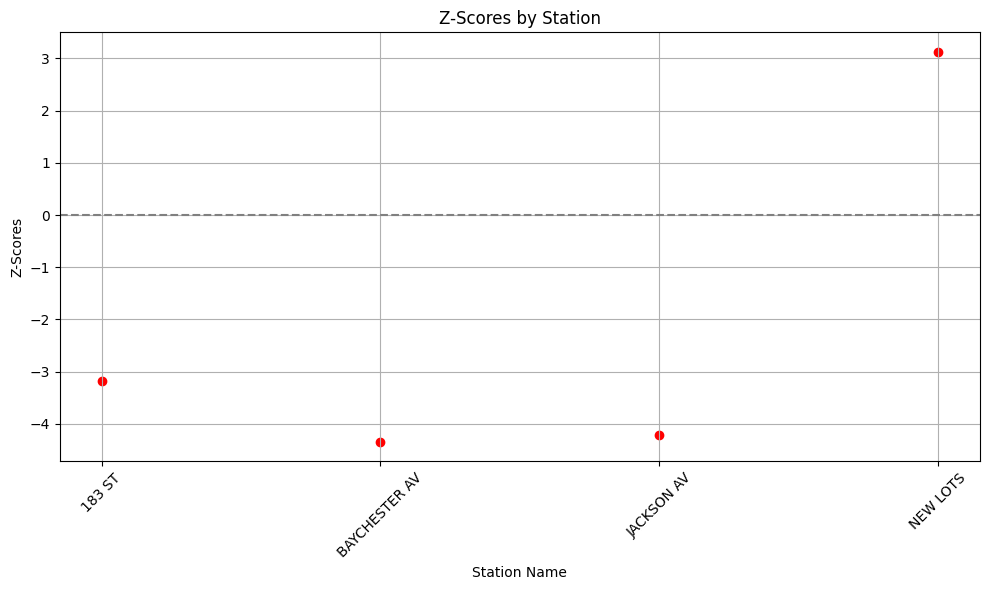

In [35]:

# get the departures and arrivals for each station at the morning and night time slots
df_morning_arrivals =  df[(df['created_dt'].dt.hour >= time_slots['morning'][0]) & (df['created_dt'].dt.hour < time_slots['morning'][1])]
df_night_departures = df[(df['created_dt'].dt.hour >= time_slots['night'][0] ) & (df['created_dt'].dt.hour < time_slots['night'][1])]
# Calculate the mean arrivals and departures for each station
mean_arrivals_by_station = df_morning_arrivals.groupby('station_name')['exits'].mean()
mean_departures_by_station = df_night_departures.groupby('station_name')['entries'].mean()

# Calculate the z-scores for the differences between mean arrivals and departures
z_scores = (mean_arrivals_by_station - mean_departures_by_station) / np.sqrt(mean_arrivals_by_station.var() + mean_departures_by_station.var())

# Set a z-score threshold to identify outliers
z_score_threshold = 3 # You can adjust this value based on your needs

# Identify stations with outliers
outlier_stations = z_scores[abs(z_scores) > z_score_threshold]

print("Stations with outliers:")
print(outlier_stations)

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(outlier_stations.index, outlier_stations.values, color='red')
plt.axhline(y=0, color='gray', linestyle='--', label='Z-Score Threshold')
plt.xlabel('Station Name')
plt.ylabel('Z-Scores')
plt.title('Z-Scores by Station')
plt.grid(True)

# Rotate x-axis labels for better readability if many stations
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()



## Statistical Analysis
> Focus on applying statistical techniques in order to draw meaningful conclusions about a set of data. It involves mathematical computations, probability theory, correlation analysis, and hypothesis testing

In [37]:
# Summary statistics
measures = ['entries','exits']
dims = ['station_name']

print("Summary Statistics:")
print(df[measures].describe() / 10000)

# Filter rows for the month of July for morning and night time slots
df_morning_july = df_morning_arrivals[df_morning_arrivals['created_dt'].dt.month == 7][measures + dims]
df_night_july = df_night_departures[df_night_departures['created_dt'].dt.month == 7][measures + dims]

correlation_data = []
for station in df_morning_july['station_name'].unique():
    morning_arrival = df_morning_july[df_morning_july['station_name'] == station]['exits'].values[0]
    evening_departure = df_night_july[df_night_july['station_name'] == station]['entries'].values[0]
    correlation_data.append({'station_name': station, 'arrivals': morning_arrival, 'departures': evening_departure})

df_correlation = pd.DataFrame(correlation_data)

# Select top 10 stations with most morning arrivals
top_stations = df_correlation.groupby('station_name')['arrivals'].sum().nlargest(10).index
df_top_stations = df_correlation[df_correlation['station_name'].isin(top_stations)]

# Create a scatter matrix to visualize relationships between numeric columns
fig_scatter = plotly_x.scatter(df_top_stations, x='arrivals', y='departures', color='station_name',
                         title='Morning Arrivals vs Evening Departures', opacity=0.75, width=980, height=650 )
fig_scatter.show()

# Create a correlation matrix
corr_matrix = df_top_stations.corr(numeric_only=True)

# Plot correlation matrix using Plotly
fig_corr = plotly_x.imshow(corr_matrix,
                x=corr_matrix.columns,
                y=corr_matrix.columns,
                title="Correlation Matrix for Top 10 Stations: Morning Arrivals vs Night Departures")

corr_matrix_all = df_correlation.corr(numeric_only=True)

# Plot correlation matrix using Plotly
fig_corr_all = plotly_x.imshow(corr_matrix_all,
                x=corr_matrix_all.columns,
                y=corr_matrix_all.columns,
                title="Correlation Matrix for all Stations: Morning Arrivals vs Night Departures")
fig_corr_all.show()


Summary Statistics:
             entries          exits
count      10.000000      10.000000
mean     3691.269728    2954.513148
std     20853.999335   18283.964419
min         0.000000       0.000000
25%        27.126200      19.537525
50%       135.898650     100.470600
75%       615.586650     445.015200
max    214717.057100  212147.622600


### Hypothesis Testing
> Pearson Correlation: This is a statistical test that measures the linear relationship between two variables. It results in a coefficient value ranging from -1 to +1 (perfect correlation), with 0 indicating no correlation.

In [34]:
# Perform Pearson correlation test
def test_arrival_departure_correlation(df: pd.DataFrame, label: str) -> None:
   corr_coefficient, p_value = pearsonr(df['arrivals'], df['departures'])   
   p_value = round(p_value, 5)
   
   if p_value < 0.05:
      conclusion = f"The correlation {label} is statistically significant."
   else:
      conclusion = f"The correlation {label} is not statistically significant."
      
   print(f"Pearson Correlation {label} - Coefficient : {corr_coefficient} P-Value : {p_value}")    
   print(f"Conclusion: {conclusion}")

test_arrival_departure_correlation(df_top_stations, 'top-10 stations')

test_arrival_departure_correlation(df_correlation, 'all stations')

Pearson Correlation top-10 stations - Coefficient : -0.1411184274451126 P-Value : 0.69738
Conclusion: The correlation top-10 stations is not statistically significant.
Pearson Correlation all stations - Coefficient : 0.738028840267009 P-Value : 0.0
Conclusion: The correlation all stations is statistically significant.


## Business Intelligence Show the total entries by station, use a subset of data

> BI is a strategic approach that involves the collection, analysis, and presentation of data to facilitate informed decision-making within an organization

In [81]:
# Divisor for trillion 
divisor_t = 1e12

def analyze_distribution(df,dimensions, measures, divisor):
  """
  This function analyzes the distribution of measures by station in a DataFrame.

  Args:
      df (pandas.DataFrame): The input DataFrame containing the data.
      dimensions (list): A list of column names representing the dimensions
      measures (list): A list of column names representing the measures to analyze.
      divisor (pandas.Series or list): The divisor to use for normalization.

  Returns:
      pandas.DataFrame: A DataFrame containing the distribution analysis by station.
  """

  # Group by station_name and calculate sum of measures
  df_dist = df.groupby([dimensions], as_index=False)[measures].sum()

  # vectorized operations - divide each column in 'measures' by the corresponding value from 'divisor'
  df_dist[measures] = df_dist[measures].div(divisor, axis=0)
  print(df_dist.head(5))

  return df_dist


In [82]:
# Calculate total passengers for arrivals and departures
total_arrivals = df['exits'].sum()/divisor_t
total_departures = df['entries'].sum()/divisor_t
print(f"Total Arrivals: {total_arrivals} Total Departures: {total_departures}")

# Create distribution analysis by station
df_by_station = analyze_distribution(df,'station_name',measures,divisor_t)

# Create distribution analysis by day of the week
df_by_date = df.groupby(["created_dt"], as_index=False)[measures].sum()
day_order = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
df_by_date["weekday"] = pd.Categorical(df_by_date["created_dt"].dt.strftime('%a'), categories=day_order, ordered=True)
df_entries_by_date = analyze_distribution(df_by_date,'weekday',measures,divisor_t)

# Create distribution analysis time slots
for slot, (start_hour, end_hour) in time_slots.items():
    slot_data = df[(df['created_dt'].dt.hour >= start_hour) & (df['created_dt'].dt.hour <= end_hour)]
    arrivals = slot_data['exits'].sum()/divisor_t
    departures = slot_data['entries'].sum()/divisor_t
    print(f"{slot.capitalize()} - Arrivals: {arrivals:.2f}, Departures: {departures:.2f}")



Total Arrivals: 2.954513147693 Total Departures: 3.691269727684
  station_name   entries     exits
0         1 AV  0.041922  0.004724
1       103 ST  0.001701  0.001505
2       104 ST  0.060736  0.035317
3       111 ST  0.001856  0.000841
4       116 ST  0.007419  0.008293
  weekday   entries     exits
0     Sun  0.083869  0.053997
1     Mon  0.839105  0.667972
2     Tue  0.723988  0.592239
3     Wed  0.728728  0.594670
4     Thu  0.080967  0.051233
Morning - Arrivals: 0.49, Departures: 0.62
Afternoon - Arrivals: 0.49, Departures: 0.62
Night - Arrivals: 0.81, Departures: 1.01
